## TsSHAP
Este notebook es un intento de replicar https://arxiv.org/abs/2303.12316 para entender si es compatible con deepVATS, que debería

In [1]:
import shap
import numpy as np
import pandas as pd

# Datasets
El primer paso es obtener los datasets. En el paper se mencionan estos: 

dataset ( size)
- jeans-sales-daily (1095)
- jeans-sales-weekly (158)
- us-unemployment (872). https://www.kaggle.com/datasets/aniruddhasshirahatti/us-unemployment-dataset-2010-2020
- peyton-maning (2905) https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv
- bike-sharing (731)


De todos ellos, voy a empezar con peyton-manning por ser el más largo (aunque todas las series son bace más directo

## Obtain the dataset

In [2]:
! wget "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"

--2024-01-16 23:14:51--  https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86845 (85K) [text/plain]
Saving to: ‘example_wp_log_peyton_manning.csv’

example_wp_log_peyt 100%[===================>]  84.81K  --.-KB/s    in 0.005s  

2024-01-16 23:14:51 (16.8 MB/s) - ‘example_wp_log_peyton_manning.csv’ saved [86845/86845]



In [3]:
df_peyton = pd.read_csv("example_wp_log_peyton_manning.csv")

In [4]:
df_peyton.shape

(2905, 2)

In [5]:
df_peyton.head

<bound method NDFrame.head of               ds          y
0     2007-12-10   9.590761
1     2007-12-11   8.519590
2     2007-12-12   8.183677
3     2007-12-13   8.072467
4     2007-12-14   7.893572
...          ...        ...
2900  2016-01-16   7.817223
2901  2016-01-17   9.273878
2902  2016-01-18  10.333775
2903  2016-01-19   9.125871
2904  2016-01-20   8.891374

[2905 rows x 2 columns]>

In [6]:
! rm "example_wp_log_peyton_manning.csv"

In [7]:
from dvats.load import TSArtifact, infer_or_inject_freq
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from fastai.tabular.all import * 
from tsai.all import *

In [8]:
peyton_time_col = 0
peyton_date_offset = 0

In [9]:
datetime = df_peyton.iloc[:, peyton_time_col]

In [10]:
datetime

0       2007-12-10
1       2007-12-11
2       2007-12-12
3       2007-12-13
4       2007-12-14
           ...    
2900    2016-01-16
2901    2016-01-17
2902    2016-01-18
2903    2016-01-19
2904    2016-01-20
Name: ds, Length: 2905, dtype: object

In [11]:
# Get original index
index = pd.DatetimeIndex(datetime)
index

DatetimeIndex(['2007-12-10', '2007-12-11', '2007-12-12', '2007-12-13',
               '2007-12-14', '2007-12-15', '2007-12-16', '2007-12-17',
               '2007-12-18', '2007-12-19',
               ...
               '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-15', '2016-01-16', '2016-01-17', '2016-01-18',
               '2016-01-19', '2016-01-20'],
              dtype='datetime64[ns]', name='ds', length=2905, freq=None)

In [12]:
# Add offset
offset_timedelta = pd.to_timedelta(peyton_date_offset, unit='D')
index += offset_timedelta

In [13]:
# Delete time column
col_name = df_peyton.columns[peyton_time_col]
df_peyton = df_peyton.drop(col_name, axis=1)
df_peyton.head

<bound method NDFrame.head of               y
0      9.590761
1      8.519590
2      8.183677
3      8.072467
4      7.893572
...         ...
2900   7.817223
2901   9.273878
2902  10.333775
2903   9.125871
2904   8.891374

[2905 rows x 1 columns]>

In [14]:
df_peyton = infer_or_inject_freq(
    df_peyton, 
    injected_freq= '1d', 
    start_date = '2007-12-10', 
    format = '%Y-%m-%d %H:%M:%S'
)
print(df_peyton.index.freq)

<Day>


In [15]:
df_peyton.head

<bound method NDFrame.head of                     y
2007-12-10   9.590761
2007-12-11   8.519590
2007-12-12   8.183677
2007-12-13   8.072467
2007-12-14   7.893572
...               ...
2015-11-18   7.817223
2015-11-19   9.273878
2015-11-20  10.333775
2015-11-21   9.125871
2015-11-22   8.891374

[2905 rows x 1 columns]>

## Backtesting

In [16]:
window_length = 30
horizon = 15
num_windows = 5

Expanding Window Split
Ver sección 4.2 del paper

In [132]:
def split_time_serie(df, window_size, horizon): 
    n = len(df)
    splits = [[],[]]
    splits_dates = [[],[]]
    for start in range(0, n, horizon):
        end_train = start + window_size + (start // horizon) * horizon

        # Asegurarse de que la ventana de entrenamiento no excede el tamaño del DataFrame
        if end_train > n:
            break

        train_dates = df.index[0:end_train]
        train = range(0,end_train)
        end_test = end_train + horizon
        # Asegurarse de que la ventana de prueba no excede el tamaño del DataFrame
        if end_test > n:
            test_dates = df.index[end_train:]
            test = range(end_train, len(test_dates))
        else:
            test_dates = df.index[end_train:end_test]
            test = range(end_train,end_test)

        splits[0].append(train)
        splits[1].append(test)
        splits_dates[0].append(train_dates)
        splits_dates[1].append(test_dates)
    return tuple(splits), tuple(splits_dates)

In [133]:
splits, splits_dates = split_time_serie(df_peyton, window_length, horizon)

In [134]:
len(splits[0])

96

In [135]:
print(splits_dates[0][0])
print(len(splits[0][0]))

DatetimeIndex(['2007-12-10', '2007-12-11', '2007-12-12', '2007-12-13',
               '2007-12-14', '2007-12-15', '2007-12-16', '2007-12-17',
               '2007-12-18', '2007-12-19', '2007-12-20', '2007-12-21',
               '2007-12-22', '2007-12-23', '2007-12-24', '2007-12-25',
               '2007-12-26', '2007-12-27', '2007-12-28', '2007-12-29',
               '2007-12-30', '2007-12-31', '2008-01-01', '2008-01-02',
               '2008-01-03', '2008-01-04', '2008-01-05', '2008-01-06',
               '2008-01-07', '2008-01-08'],
              dtype='datetime64[ns]', freq='D')
30


In [136]:
print(splits_dates[1][0])
print(len(splits[1][0]))

DatetimeIndex(['2008-01-09', '2008-01-10', '2008-01-11', '2008-01-12',
               '2008-01-13', '2008-01-14', '2008-01-15', '2008-01-16',
               '2008-01-17', '2008-01-18', '2008-01-19', '2008-01-20',
               '2008-01-21', '2008-01-22', '2008-01-23'],
              dtype='datetime64[ns]', freq='D')
15


In [143]:
print(splits[0][0])
print(splits[0][1])

range(0, 30)
range(0, 60)


In [144]:
print(splits[1][0])
print(splits[1][1])

range(30, 45)
range(60, 75)


In [145]:
print(splits_dates[0][95])
print(splits[0][95])
print(splits[1][95])

DatetimeIndex(['2007-12-10', '2007-12-11', '2007-12-12', '2007-12-13',
               '2007-12-14', '2007-12-15', '2007-12-16', '2007-12-17',
               '2007-12-18', '2007-12-19',
               ...
               '2015-10-19', '2015-10-20', '2015-10-21', '2015-10-22',
               '2015-10-23', '2015-10-24', '2015-10-25', '2015-10-26',
               '2015-10-27', '2015-10-28'],
              dtype='datetime64[ns]', length=2880, freq='D')
range(0, 2880)
range(2880, 2895)


In [116]:
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from warnings import simplefilter

def plot_windows(y, train_windows, test_windows, num_windows = 5, title=""):
    """Visualize training and test windows."""
    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        """Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))
    
    for i in range(min(n_splits, num_windows)):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            y.index[train], get_y(len(train), i), marker="o", c=train_color, 
            label="Entrenamiento" if i == 0 else ""
        )
        ax.plot(
            y.index[test], get_y(len(test), i), marker="o", c=test_color, 
            label="Prueba" if i == 0 else ""
        )
        
        ax.invert_yaxis()
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set(
            title=title,
            ylabel="Número de ventana",
            xlabel="Tiempo"
        )

    # Set the x-ticks to be the index of y, rotated for better readability
    ax.set_xticks(y.index)
    ax.set_xticklabels([str(idx) for idx in y.index], rotation=90, ha='right')

    # Seleccionar un subconjunto de etiquetas para mostrar
    ticks_to_show = np.linspace(0, n_timepoints - 1, min(20, n_timepoints), dtype=int)
    ax.set_xticks(y.index[ticks_to_show])
    ax.set_xticklabels([str(y.index[idx]) for idx in ticks_to_show], rotation=90, ha='right')

    # Remove duplicate labels/handles
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.tight_layout()  # Ajustar el layout para evitar solapamientos
    plt.show()


In [146]:
train_windows, test_windows = splits

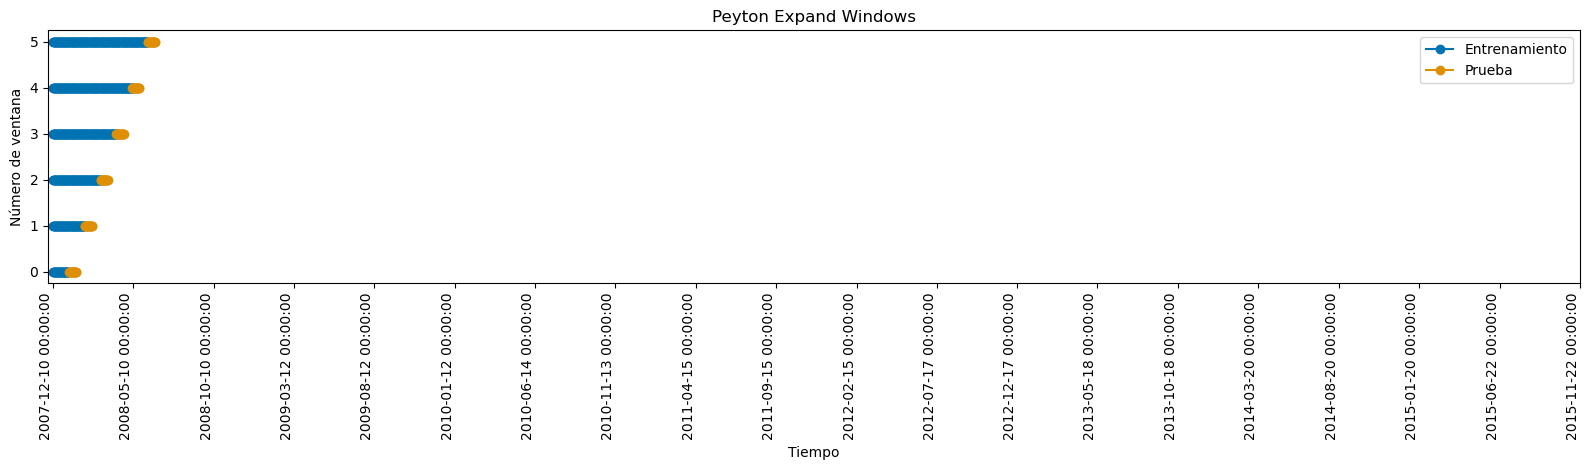

In [150]:
plot_windows(df_peyton, train_windows, test_windows, num_windows = 6, title   = "Peyton Expand Windows")

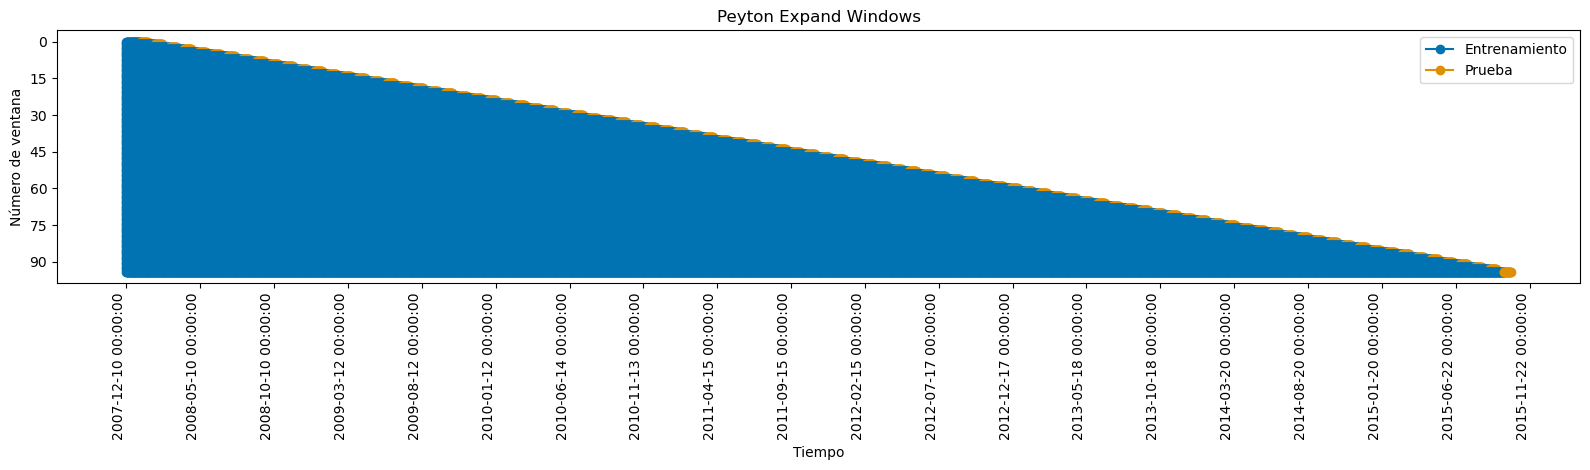

In [149]:
plot_windows(df_peyton, train_windows, test_windows, num_windows = 95, title   = "Peyton Expand Windows")

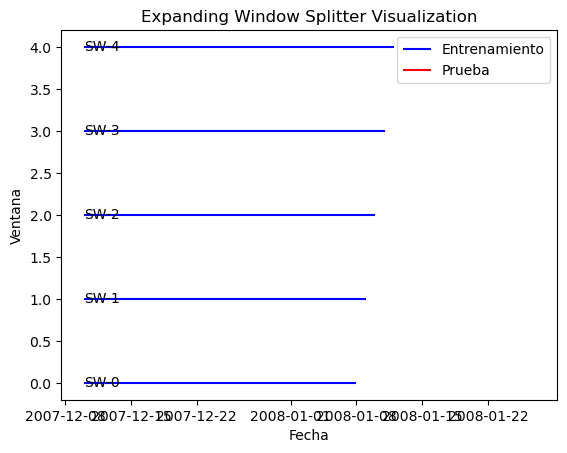

In [26]:
for i, (train, test) in enumerate(islice(splits, num_windows)):
    # Añadir líneas para representar las ventanas de entrenamiento y prueba
    plt.hlines(y=i, xmin=df_peyton.index[train[0]], xmax=df_peyton.index[train[-1]], colors='blue', label="Entrenamiento" if i == 0 else "")
    plt.hlines(y=i, xmin=df_peyton.index[test[0]], xmax=df_peyton.index[test[-1]], colors='red', label="Prueba" if i == 0 else "")
    plt.text(df_peyton.index[0], i, f"SW-{i}", verticalalignment='center')

# Añadir leyendas y etiquetas
plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Ventana")
plt.title("Expanding Window Splitter Visualization")
plt.show()

In [38]:
def expanding_window_splits(data, window_length):
    splits = []
    splits_dates = []
    for i in range(window_length, len(data)):
        train_idx = L(range(i - window_length, i))
        val_idx = L(range(i, i + 1))
        splits.append((train_idx, val_idx))
        splits_dates.append((data.index[train_idx], data.index[val_idx]))
        splits
    return splits, splits_dates

In [39]:
splits, splits_dates = expanding_window_splits(df_peyton, window_length)

In [41]:
splits[:5]

[((#30) [0,1,2,3,4,5,6,7,8,9...], (#1) [30]),
 ((#30) [1,2,3,4,5,6,7,8,9,10...], (#1) [31]),
 ((#30) [2,3,4,5,6,7,8,9,10,11...], (#1) [32]),
 ((#30) [3,4,5,6,7,8,9,10,11,12...], (#1) [33]),
 ((#30) [4,5,6,7,8,9,10,11,12,13...], (#1) [34])]

In [42]:
splits_dates[:5]

[(DatetimeIndex(['2007-12-10', '2007-12-11', '2007-12-12', '2007-12-13',
                 '2007-12-14', '2007-12-15', '2007-12-16', '2007-12-17',
                 '2007-12-18', '2007-12-19', '2007-12-20', '2007-12-21',
                 '2007-12-22', '2007-12-23', '2007-12-24', '2007-12-25',
                 '2007-12-26', '2007-12-27', '2007-12-28', '2007-12-29',
                 '2007-12-30', '2007-12-31', '2008-01-01', '2008-01-02',
                 '2008-01-03', '2008-01-04', '2008-01-05', '2008-01-06',
                 '2008-01-07', '2008-01-08'],
                dtype='datetime64[ns]', freq=None),
  DatetimeIndex(['2008-01-09'], dtype='datetime64[ns]', freq=None)),
 (DatetimeIndex(['2007-12-11', '2007-12-12', '2007-12-13', '2007-12-14',
                 '2007-12-15', '2007-12-16', '2007-12-17', '2007-12-18',
                 '2007-12-19', '2007-12-20', '2007-12-21', '2007-12-22',
                 '2007-12-23', '2007-12-24', '2007-12-25', '2007-12-26',
                 '2007-12-27',

In [21]:
def plot_splits(data, splits, title='Expanding Window Splits'):
    plt.figure(figsize=(10, 6))
    plt.plot(data, label='Data')

    for i, (train_idx, val_idx) in enumerate(splits):
        plt.scatter(train_idx, data[train_idx], color='green', s=10, label='Training' if i == 0 else '')
        plt.scatter(val_idx, data[val_idx], color='red', s=10, label='Validation' if i == 0 else '')

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [52]:
import matplotlib.dates as mdates

def plot_expanding_window(data, splits, num_windows=5, title='Expanding Window Plot'):
    plt.figure(figsize=(15, 5))

    # Asegurarse de que el índice sea una serie de tiempo
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # Plot the actual data
    plt.plot(data.index, data.values, label='Data', color='lightgrey')

    # Plot the training and validation periods
    for i, (train_indices, val_indices) in enumerate(splits[:num_windows]):
        # Shade the area for the training window
        plt.axvspan(data.index[train_indices[0]], data.index[train_indices[-1]], facecolor='blue', alpha=0.3)
        # Mark the validation points
        plt.scatter(data.index[val_indices], data.iloc[val_indices], color='red', zorder=5)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.gcf().autofmt_xdate()  # Auto format date labels
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

    plt.show()

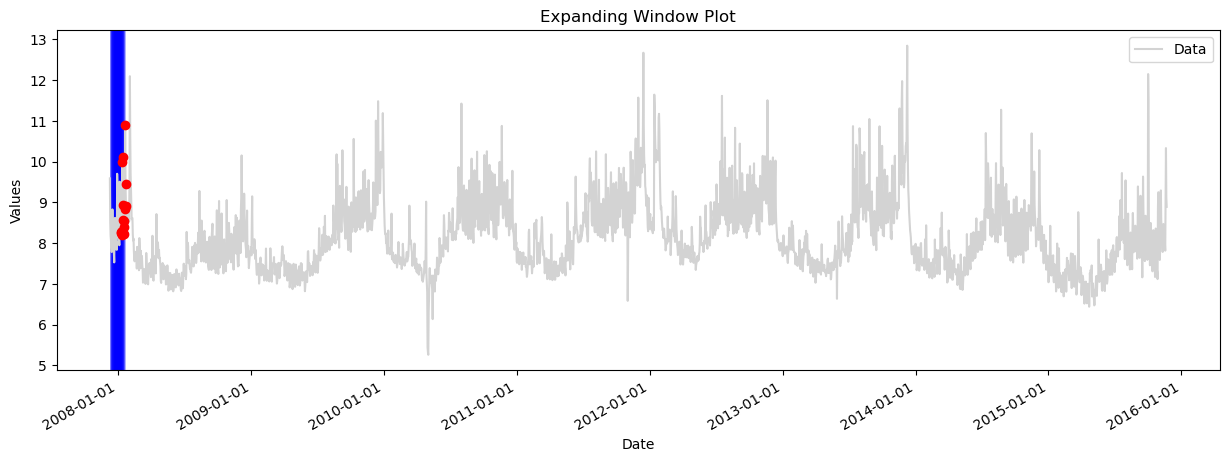

In [53]:
plot_expanding_window(df_peyton[col_name], splits, horizon, )

In [31]:
def plot_expanding_windows_horizontal(data, splits, num_windows=5, title='Expanding Window Plot'):
    plt.figure(figsize=(15, 5))
    
    # Plot the actual data
    plt.plot(data.index, data.values, label='Data', color='lightgrey')
    
    # Plot the training and validation periods
    for i, (train_indices, val_indices) in enumerate(splits[:num_windows]):
        # Shade the area for the training window
        plt.axvspan(train_indices[0], train_indices[-1], facecolor='blue', alpha=0.3)
        # Mark the validation points
        plt.scatter(val_indices, data.iloc[val_indices], color='red', zorder=5)
        
        # Optionally, add annotations for window start and end
        plt.annotate(f'Window {i+1} start', (train_indices[0], data.min()), textcoords="offset points", xytext=(-15,-10), ha='center')
        plt.annotate(f'Window {i+1} end', (train_indices[-1], data.min()), textcoords="offset points", xytext=(-15,-10), ha='center')
    
    plt.title(title)
    plt.xlabel('Index')

IndexError: positional indexers are out-of-bounds

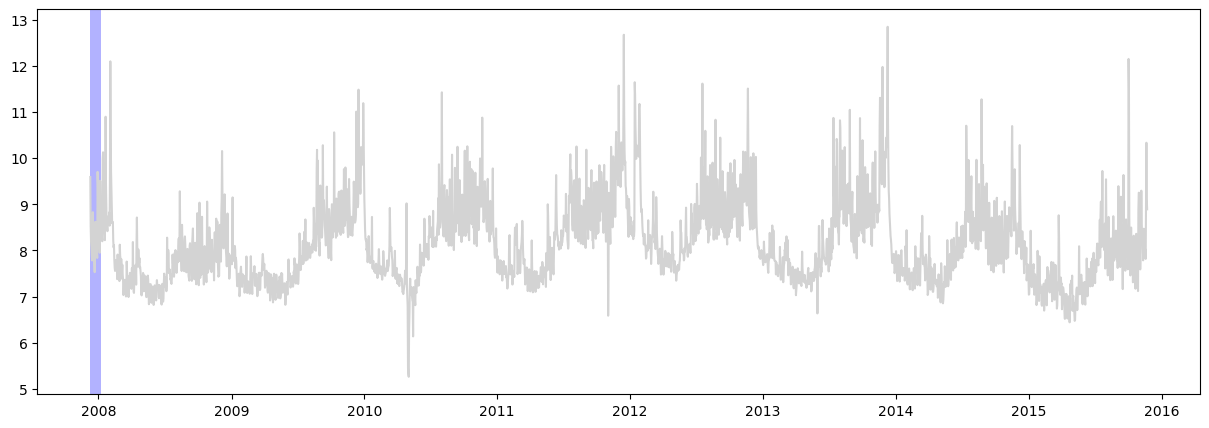

In [49]:
plot_expanding_windows_horizontal(df_peyton[col_name], splits_dates, horizon)

In [65]:
dls = get_ts_dls(df_peyton, splits=splits)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2875, 2) + inhomogeneous part.

In [ ]:
model = create_model(InceptionTime, dls=dls)

## Regressor reduction